## Transfer Learning using the MobileNetV2 convolutional base

In [43]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Flatten


In [44]:
base_dir = os.getcwd()
dir = os.path.join(base_dir, "data", "Garbageclassification", "Garbageclassification")
classes=["cardboard","glass","metal","paper","plastic","trash"]

In [45]:
def load_data(path,size):
    images = []
    labels = []
    class_names = []
    
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size)
                    images.append(img)
                    labels.append(classes.index(class_name))
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

## load data

In [46]:
imgs_data,labels_data = load_data(dir,(224,224))

In [47]:
print(imgs_data.shape,labels_data.shape)

(2527, 224, 224, 3) (2527,)


## Apply augmentation to the dataset

In [48]:
# Define the image data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images in the range 0-20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by 20% of the height
    shear_range=0.2,           # Randomly shear images
    zoom_range=0.2,            # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in newly created pixels after rotation or shift
)

# Augment the dataset
augmented_images = []
augmented_labels = []

augmentation_count = int(len(imgs_data)*3)

for img, label in zip(imgs_data, labels_data):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))
        augmented_labels.append(label)
        i += 1
        if i >= (augmentation_count / len(imgs_data)):
            break

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine the original and augmented data
final_imgs_data = np.concatenate((imgs_data, augmented_images), axis=0)
final_labels_data = np.concatenate((labels_data, augmented_labels), axis=0)

In [49]:
print("Size before augmentation : ",imgs_data.shape[0])
print("Size After augmentation : ",final_imgs_data.shape[0])

Size before augmentation :  2527
Size After augmentation :  10108


## Split the data

In [50]:
# Split data into training+validation (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(final_imgs_data, final_labels_data, test_size=0.2, random_state=42)

## Transfer Learning with MobileNetV2

### Normalize Data

In [51]:
# Normalize your image data
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

### Define the MobileNetV2 model

In [52]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

### Freeze the base model

In [53]:
base_model.trainable = False

### Create a new model on top

In [54]:
model = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # assuming classification task
])


### Compile the model

In [55]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

### Define early stopping callback

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### Train the model

In [57]:
# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 129s 601ms/step - loss: 0.9453 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.5008 - val_sparse_categorical_accuracy: 0.8164
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 121s 597ms/step - loss: 0.1818 - sparse_categorical_accuracy: 0.9417 - val_loss: 0.3910 - val_sparse_categorical_accuracy: 0.8511
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 120s 593ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.3590 - val_sparse_categorical_accuracy: 0.8721
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 117s 576ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.3447 - val_sparse_categorical_accuracy: 0.8801
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 114s 564ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.3769 - val_sparse_categorical_accuracy: 0.8721
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 115s 568ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.3685 - val_sparse_categoric

### Evaluate the model

In [58]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 426ms/step - loss: 0.3251 - sparse_categorical_accuracy: 0.9049
Test accuracy: 0.909990131855011


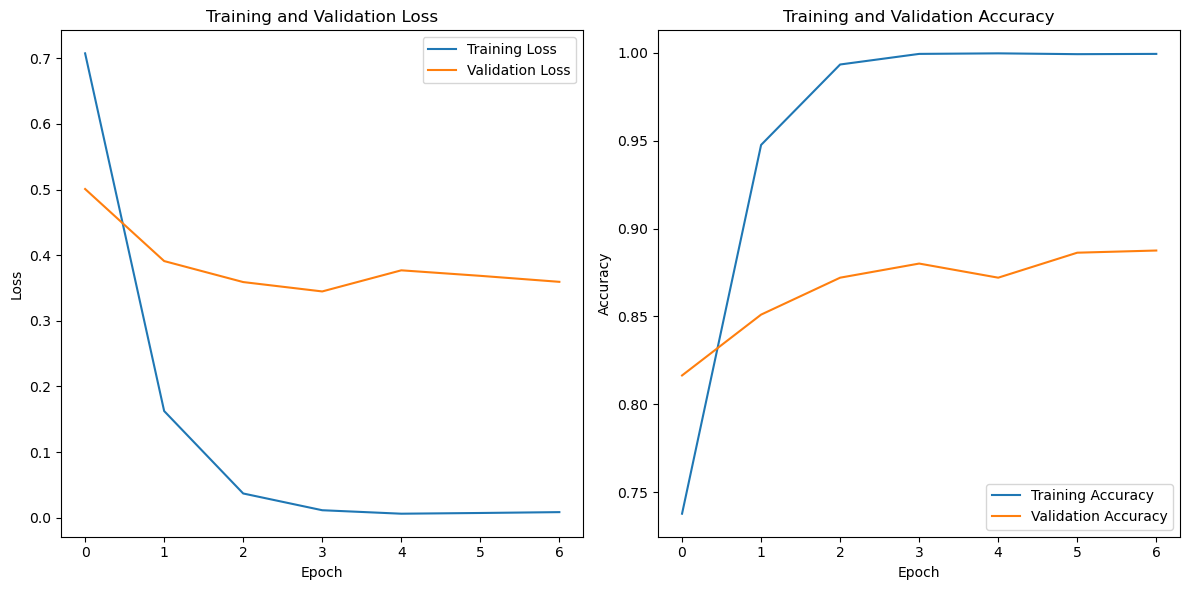

In [59]:
# Extracting history from training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()